<a href="https://colab.research.google.com/github/asokraju/Control-Systems/blob/master/Buck_Converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Control of buck converter

In this script, we simulate the input shaping controllers proposed in [Differentiation and Passivity for Control of Brayton-Moser Systems](https://arxiv.org/abs/1811.02838)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns

The dynamics of the Buck converter are:
\begin{align}
-L\dot{I} &= RI+V-uV_s\\
C\dot{V} &= I-GV
\end{align}

The proposed controller for this system is:
\begin{align}
-k_d \dot{u} &= k_i(u-u_d)+V_s \dot{I}
\end{align}

In [0]:
#@title ##Use slider to change the parameters

#@markdown ---

#@markdown ###System Parameters (Units in milli).
Capacitance = 1 #@param {type:"slider", min:1, max:100, step:0.1}
Inductance = 1 #@param {type:"slider", min:1, max:100, step:0.1}

Resistance = 0 #@param {type:"slider", min:0, max:100, step:0.1}
load = 40 #@param {type:"slider", min:1, max:100, step:0.1}

#@markdown Voltage Source.
Vs = 380 #@param {type:"slider", min:100, max:500, step:10}

#@markdown Desired Voltage.
Vd = 280 #@param {type:"slider", min: 100, max:500, step:10}

#@markdown ---
#@markdown Initial conditions.
current = -45.9 #@param {type:"slider", min:-500, max:500, step:0.1}
voltage = 191.2 #@param {type:"slider", min:0.0, max:500, step:0.1}
duty_ratio = 0.49 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
#@markdown ---
#@markdown ---
#@markdown Simulation parameters.
Simulation_time = 4.45 #@param {type:"slider", min:0.01, max:10, step:0.01}
perturbation_time = 4.19 #@param {type:"slider", min:0.01, max:10, step:0.01}
load_new = 80 #@param {type:"slider", min:1, max:100, step:0.1}

#@markdown #### At time t = perturbation_time, the load has been changed from 
C = Capacitance*1e-3
L = Inductance*1e-3
R = Resistance*1e-3
G = load*1e-3
G_new = load_new*1e-3

print('The simulation will be conducted for a total of {} milli seconds'.format(Simulation_time))
print('At time t = {} milli seconds, the load will be changed from {} to {}'.format(perturbation_time, G, G_new))


The simulation will be conducted for a total of 4.45 milli seconds
At time t = 4.19 milli seconds, the load will be changed from 0.04 to 0.08


In [0]:
# system parameters
#L, C = 0.001,0.001
#R, G = 0,0.04
#Vs = 400

# tuning params for the controller
#kd, ki = 1.6e5, 80e6
#@markdown Tuning Parameters (units 10^6).
Kd = 0.16 #@param {type:"slider", min:0.1, max:100, step:0.01}
Ki = 80 #@param {type:"slider", min:0.1, max:100, step:0.01}

kd, ki = Kd*1e6, Ki*1e6
# desired operating point
#Vd= 380
ud = Vd/Vs
Id = G*Vd


# function that returns dy/dt
def model(y,t):
  '''This contains the closed loop system dynamics, i.e., the system dynamics together with controller dynamics'''
  u,i,v=y[0],y[1],y[2]
  #model
  if t>0.1:
    'To verify the robustness we are changing the load at time t = 0.3'
    G_load = G_new
  else:
    G_load = G
  didt = -(1/L)*(R*i+v-u*Vs)
  dvdt = (1/C)*(i-G_load*v)
  # dynamic controller
  dudt = -(1/kd)*(ki*(u-ud)+Vs*didt)
  dydt=[dudt, didt,dvdt]
  return dydt
# initial condition
#y0 = [.1,22.5,100]
y0 = [duty_ratio, current, voltage]

# time points
t = np.linspace(0,.2,1000)

# solve ODE
y = odeint(model,y0,t)


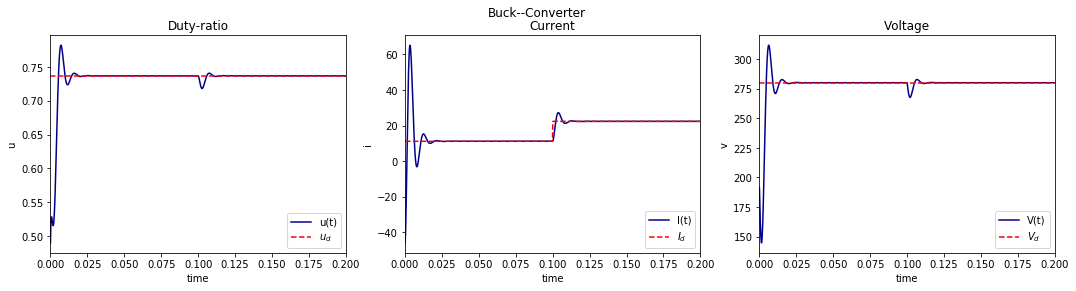

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
axes[0].plot(t,y[:,0], color = 'darkblue')
axes[0].plot(t,np.full(np.shape(t),ud),linestyle='dashed', color = 'red')
axes[0].legend(['u(t)','$u_d$'],loc='lower right')

axes[1].plot(t,y[:,1], color = 'darkblue')
def fun(time):
  '''list comprehension to encorporate the change in the desired values'''
  if time > .1:
      return Vd*0.08
  else:
      return Vd*0.04
axes[1].plot(t,[fun(time) for time in t],linestyle='dashed', color = 'red')
axes[1].legend(['I(t)','$I_d$'],loc='lower right')

axes[2].plot(t,y[:,2], color = 'darkblue')
axes[2].plot(t,np.full(np.shape(t),Vd),linestyle='dashed', color = 'red')
axes[2].legend(['V(t)','$V_d$'],loc='lower right')

axes[0].set_title("Duty-ratio")
axes[1].set_title("Current")
axes[2].set_title("Voltage")

axes[0].set_xlabel("time")
axes[1].set_xlabel("time")
axes[2].set_xlabel("time")

axes[0].set_ylabel("u")
axes[1].set_ylabel("i")
axes[2].set_ylabel("v")

axes[0].set_xlim(0,.2)
axes[1].set_xlim(0,.2)
axes[2].set_xlim(0,.2)

# Setting the ylabel to '% change'
# ... YOUR CODE FOR TASK 7 ...
#axes[0].set_ylabel('# change')
#axes[1].set_ylabel('% change')
plt.suptitle('Buck--Converter')
plt.show()
